In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Data Loading and Preprocessing
# Load the JSON file
df = pd.read_json("logins.json")

In [33]:

# Convert the 'login_time' column to datetime objects
df['login_time'] = pd.to_datetime(df['login_time'])

# 2. Aggregation to 15-Minute Intervals
# Set 'login_time' as index, resample to 15min intervals, and use .size() to count logins
# .reset_index(name='login_count') converts the Series back to a DataFrame with a named column
df_logins_15min = df.set_index('login_time').resample('15min').size().reset_index(name='login_count')

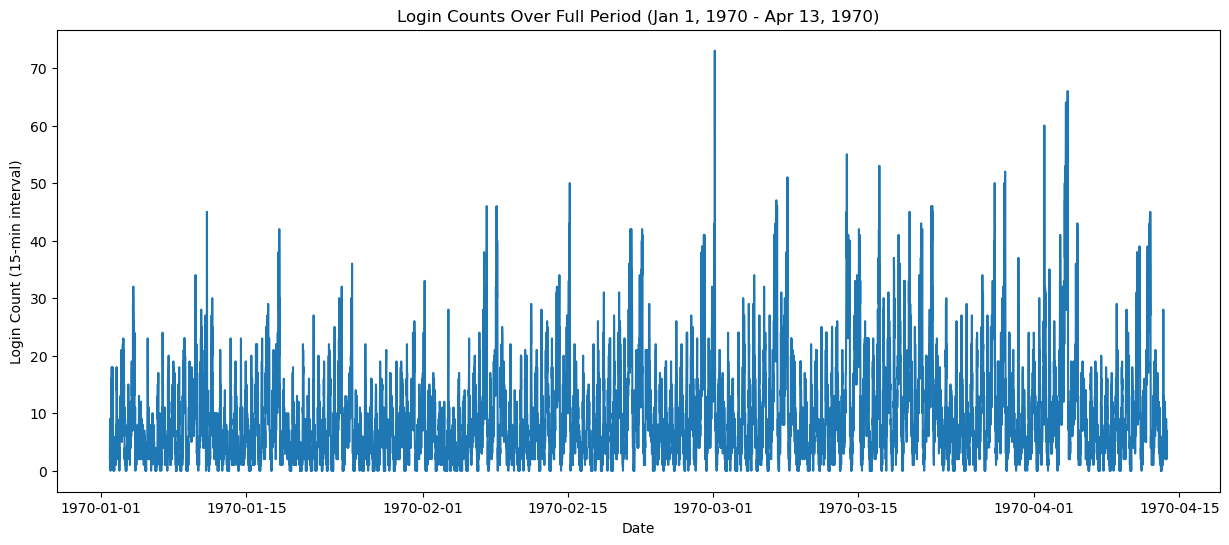

In [35]:
# 3. Visualization 1: Full Time Series (Trend and overall pattern)
plt.figure(figsize=(15, 6))
plt.plot(df_logins_15min['login_time'], df_logins_15min['login_count'])
plt.title('Login Counts Over Full Period (Jan 1, 1970 - Apr 13, 1970)')
plt.xlabel('Date')
plt.ylabel('Login Count (15-min interval)')
plt.show()


C:\Users\sreeh\AppData\Local\Temp\ipykernel_24700\2706021216.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weekly_cycle = df_logins_15min.groupby(['day_of_week', 'time_of_day'])['login_count'].mean().reset_index()


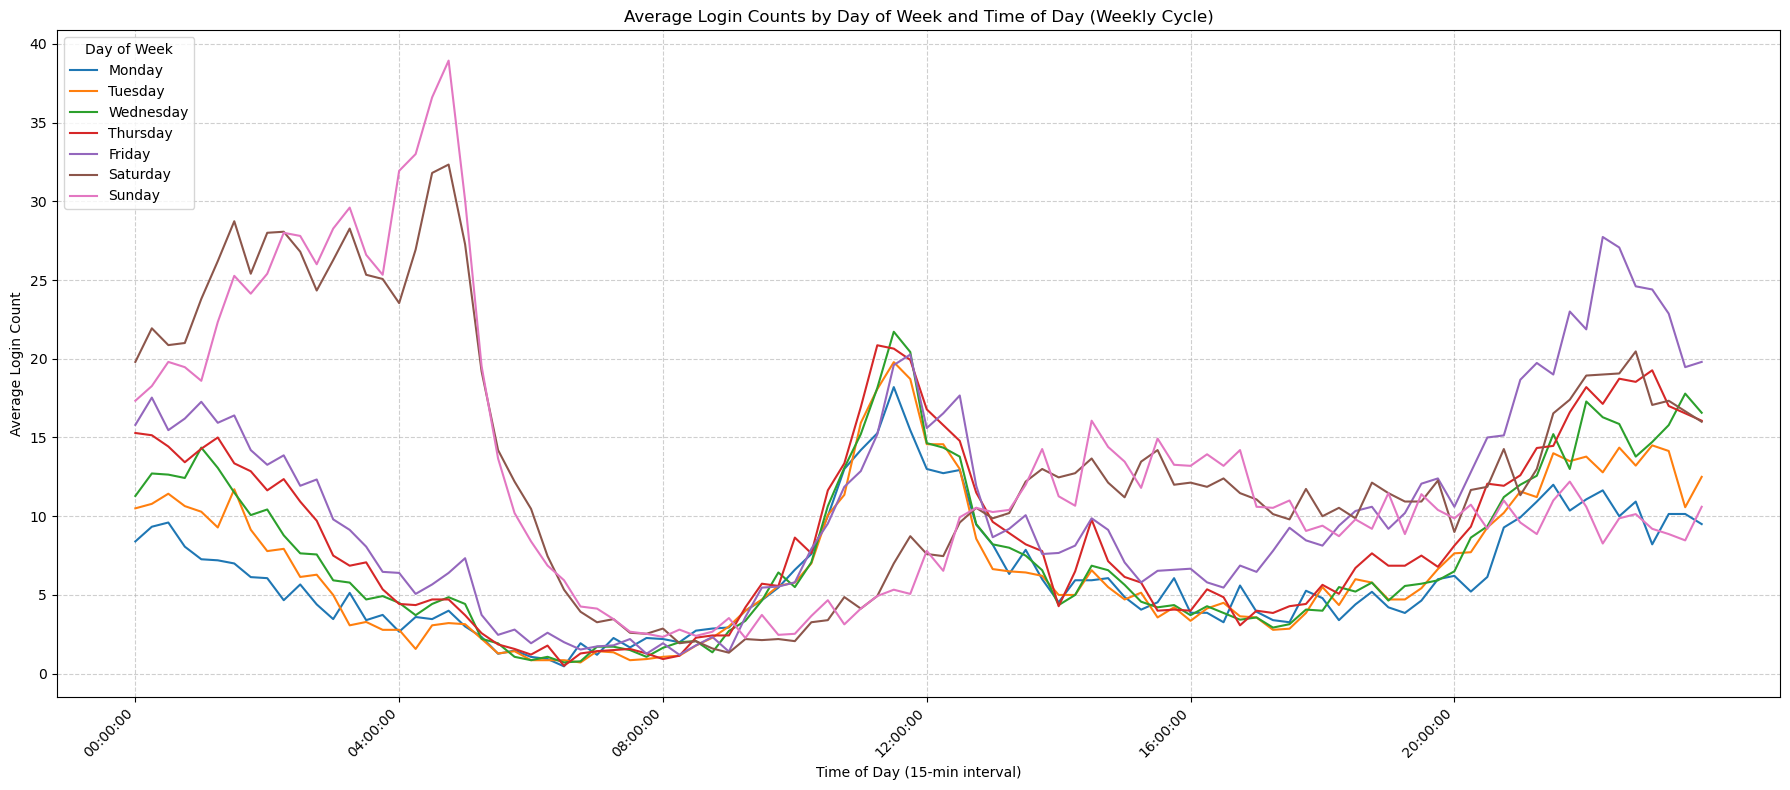

In [39]:
#Visualization 2: Weekly Cycle (Aggregated by day of week and time of day)
# Create new columns for analysis
df_logins_15min['day_of_week'] = df_logins_15min['login_time'].dt.day_name()
df_logins_15min['time_of_day'] = df_logins_15min['login_time'].dt.time.astype(str)

# Map days to sort order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_logins_15min['day_of_week'] = pd.Categorical(df_logins_15min['day_of_week'], categories=day_order, ordered=True)

# Calculate the mean login count for each day of the week and 15-minute interval
weekly_cycle = df_logins_15min.groupby(['day_of_week', 'time_of_day'])['login_count'].mean().reset_index()

# Plot the weekly cycle
plt.figure(figsize=(18, 8))
for day in day_order:
    day_data = weekly_cycle[weekly_cycle['day_of_week'] == day]
    plt.plot(day_data['time_of_day'], day_data['login_count'], label=day)

# Improve x-axis readability by showing only labels every 4 hours (every 16th interval)
x_labels = day_data['time_of_day'].iloc[::16]
x_ticks = range(0, len(day_data['time_of_day']), 16)
plt.xticks(x_ticks, x_labels, rotation=45, ha='right')

plt.title('Average Login Counts by Day of Week and Time of Day (Weekly Cycle)')
plt.xlabel('Time of Day (15-min interval)')
plt.ylabel('Average Login Count')
plt.legend(title='Day of Week', loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
""" 
Answer to part 1: 
A. Weekday Demand (Monday-Thursday)
Morning Peak: There is a moderate spike in logins between 8:00 AM and 10:00 AM, corresponding to the start of the workday.

Evening Peak: A secondary, more significant peak occurs around 9:00 PM to 11:00 PM (the post-dinner social media/leisure time).

Overnight Trough: Demand is lowest between 3:00 AM and 6:00 AM.

Consistency: The demand pattern remains relatively stable from Monday through Thursday.

B. Weekend Demand (Friday-Sunday)
The demand profile shifts radically on the weekend, indicating a change in user behavior and location usage:

Friday: Shows a significant late-night spike, peaking sharply between 10:00 PM and 1:00 AM (early Saturday). This is the highest single peak of the week, suggesting a heavy social or late-evening usage pattern.

Saturday/Sunday: Demand is consistently higher throughout the day than on weekdays, but the late-night peak is the most pronounced:

Saturday has a sustained high demand from 10:00 AM onward, peaking around 1:00 AM to 4:00 AM (early Sunday).

Sunday follows a similar, slightly lower pattern, with a late-night peak as well.

Summary of Key Demand Periods
The highest demand for logins occurs late at night and into the early morning hours on weekends (especially Friday and Saturday nights), suggesting a social or entertainment use case rather than a strictly professional one.

The daily cycles are highly pronounced, confirming the need for time-based forecasting models for this location's demand.
"""

In [ ]:
"""
Answer to Part 2:

We can compare pre-toll vs. post-toll ridership using A/B testing. If drivers being exclusive to one city really affects business then it must be because of lack of supply, extending the waiting times for riders and driving the cost higher as well. We can then use these characteristics as the metric as basis for comparison:

Compare daily average wait times (time driver arrives vs. time rider sends request) in either city prior to the change and after
Compare daily average price during rush hour (dollar per mile cost that includes surge pricing due to demand) prior to the change and after
Compare daily rate of denied service (i.e. how many times users are turned down for being too far) prior to the change and after
These parameters can simply be extracted from the internal database before and after the implementation of the reimbursement program. The hypothesis testing will be done on each of the three metrics above. Using the first item, average wait times, as an example, the null hypothesis would be that the difference between the two means will be zero (or that they are equal).

Now, since the statistic is daily, we can use a timeframe (say, 20 days) in which each day is a trial of the experiment -- so it will be 20 days during without reimbursement period, compared with 20 days during with reimbursement period. This will ensure randomness as long as this sample is not more than 10% of the actual length of the period (so the program must go on for at least 200 days).

From there, we can simulate the assumption of our null hypothesis by shuffling the labels of our means (half of the sample is randomly assigned as have occurred with reimbursement). Let's say that the target for the average wait time is a 10-second improvement -- our observed test statistic. The p-value is then the probability that a user waited 10-seconds less than when there was no reimbursement in these randomized circumstances. If this event happens less frequently than 5% of the time, then we know it's unlikely to occur. And so encountering a difference of 10-seconds waiting time is considered to be statistically significant.

If we disprove the null hypothesis (the status quo) for all the three metrics, then we have proven that the reimbursement program works. The next step then is to contrast the cost of the total reimbursements against the gains in revenue. And as contingency, also work out the impact of reverting back to the unsubsidized approach.

"""

In [45]:
import warnings
from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [47]:
import pandas as pd
import json

#save file to memory
file = open("ultimate_data_challenge.json", "r")
dataset = file.read()
file.close()

#load file as JSON
data = json.loads(dataset)

#create df from JSON dataset
df = pd.DataFrame(data)

#parse dates
df["last_trip_date"] = pd.to_datetime(df["last_trip_date"])
df["signup_date"] = pd.to_datetime(df["signup_date"])
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [49]:
active = lambda row: 1 if row != 0 else 0
df["active"] = df["trips_in_first_30_days"].apply(active)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,1
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,1


C:\Users\sreeh\AppData\Local\Temp\ipykernel_24700\644929688.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(["Inactive Users", "Active Users"])


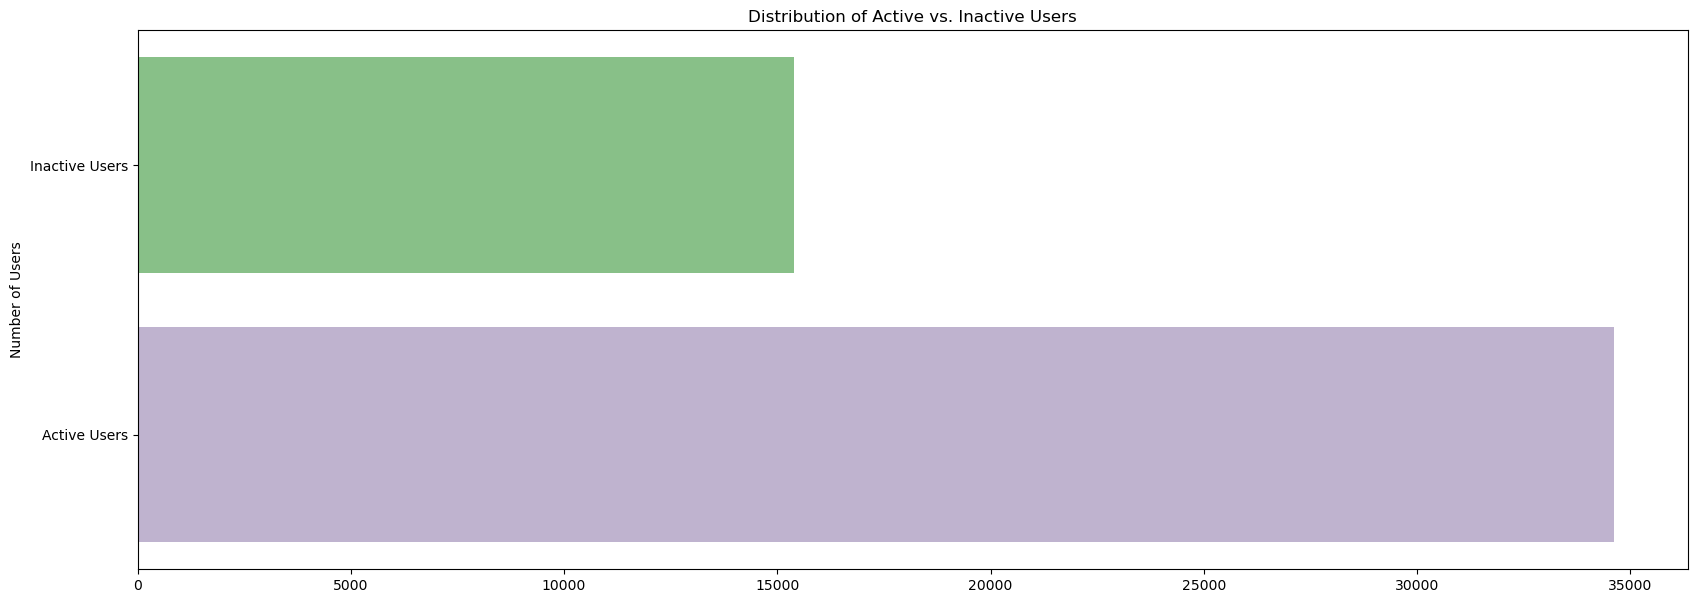

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
f, axes = plt.subplots(figsize=(20,7))
ax = sns.countplot(y=df["active"], palette="Accent")
ax.set(title="Distribution of Active vs. Inactive Users", \
       xlabel="", ylabel="Number of Users")
ax.set_yticklabels(["Inactive Users", "Active Users"])
plt.show()

ValueError: The number of FixedLocator locations (12), usually from a call to set_ticks, does not match the number of labels (11).

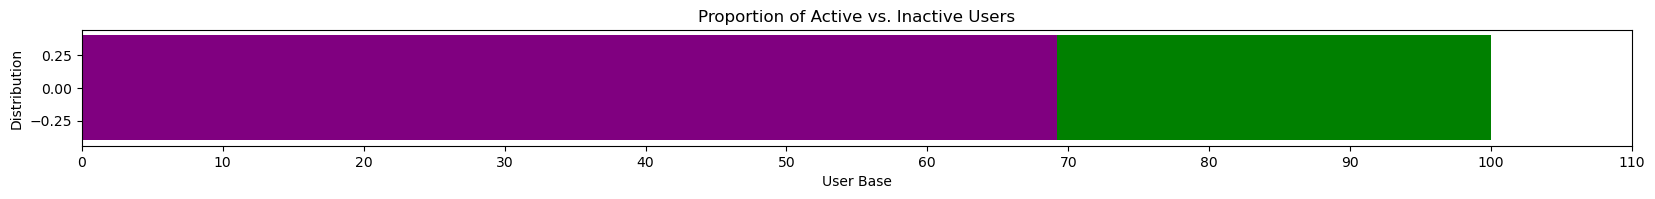

In [55]:
#active user stats
active_count = len(df[df["active"] == 1])
active_pct = active_count/len(df) * 100

#inactive user stats
inactive_count = len(df[df["active"] == 0])
inactive_pct = inactive_count/len(df) * 100

f, axes = plt.subplots(figsize=(20,1.5))

#stacked bar plot
plt.barh(y=0, width=inactive_pct, left=active_pct, color="green")
plt.barh(y=0, width=active_pct, color="purple")

#plot characteristics
plt.title("Proportion of Active vs. Inactive Users")
plt.xlabel("User Base")
plt.ylabel("Distribution")
plt.xticks(ticks = range(0, 111, 10), \
           labels = [str(i)+"%" for i in range(0, 101, 10)])
plt.yticks(ticks = [])
plt.legend(["Active", "Inactive"], loc="center right")

plt.show()

In [57]:
from datetime import timedelta

sixth_month_active = lambda row: 1 if \
                      row["last_trip_date"] - row["signup_date"] \
                      > timedelta(days=30*5) \
                      else 0

df["sixth_month_active"] = df.apply(sixth_month_active, axis=1)

df[["signup_date", "last_trip_date", "sixth_month_active"]].head()

,signup_date,last_trip_date,sixth_month_active
0,2014-01-25,2014-06-17,0
1,2014-01-29,2014-05-05,0
2,2014-01-06,2014-01-07,0
3,2014-01-10,2014-06-29,1
4,2014-01-27,2014-03-15,0


In [59]:
df = df.drop(columns = ["last_trip_date", "signup_date"])
print(df.isna().any())

city                      False
trips_in_first_30_days    False
avg_rating_of_driver       True
avg_surge                 False
phone                      True
surge_pct                 False
ultimate_black_user       False
weekday_pct               False
avg_dist                  False
avg_rating_by_driver       True
active                    False
sixth_month_active        False
dtype: bool


In [61]:
import numpy as np

#replace avg_rating_by_driver NaNs with mean
mean = df["avg_rating_by_driver"].mean()
rating = lambda row: mean if np.isnan(row) else row
df["avg_rating_by_driver"] = df["avg_rating_by_driver"].apply(rating)

#replace avg_rating_of_driver NaNs with mean
mean = df["avg_rating_of_driver"].mean()
rating = lambda row: mean if np.isnan(row) else row
df["avg_rating_of_driver"] = df["avg_rating_of_driver"].apply(rating)

In [63]:
other = lambda row: "Other" if type(row) != str else row
df["phone"] = df["phone"].apply(other)

print(df["phone"].unique())

['iPhone' 'Android' 'Other']


In [65]:
other = lambda row: "Other" if type(row) != str else row
df["phone"] = df["phone"].apply(other)

print(df["phone"].unique())

['iPhone' 'Android' 'Other']


In [67]:
#preprocessing
df["ultimate_black_user"] = df["ultimate_black_user"].map({False:0, True:1}).astype("category")
df["active"] = df["active"].astype("category")
df.head()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active,sixth_month_active
0,King's Landing,4,4.7,1.10,iPhone,15.4,1,46.2,3.67,5.0,1,0
1,Astapor,0,5.0,1.00,Android,0.0,0,50.0,8.26,5.0,0,0
2,Astapor,3,4.3,1.00,iPhone,0.0,0,100.0,0.77,5.0,1,0
3,King's Landing,9,4.6,1.14,iPhone,20.0,1,80.0,2.36,4.9,1,1
4,Winterfell,14,4.4,1.19,Android,11.8,0,82.4,3.13,4.9,1,0


In [69]:
from sklearn.model_selection import train_test_split

X = df[df.columns[:-1]]
y = df[df.columns[-1]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=42)

display(X_train.head())
display(y_train.head())

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
28521,Winterfell,11,4.5,1.00,iPhone,0.0,0,48.6,2.06,4.7,1
45679,King's Landing,1,5.0,1.10,iPhone,6.5,1,90.3,3.26,4.9,1
33494,Winterfell,0,4.0,1.00,iPhone,0.0,1,50.0,3.10,4.5,0
37673,Astapor,0,5.0,1.00,Android,0.0,0,100.0,30.48,5.0,0
11486,Winterfell,0,5.0,1.38,iPhone,50.0,0,0.0,3.93,5.0,0


28521    1
45679    1
33494    0
37673    0
11486    0
Name: sixth_month_active, dtype: int64

In [71]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

#pipeline for numeric features
numeric_features = ["avg_dist", "avg_rating_by_driver", "avg_rating_of_driver", \
                    "avg_surge", "surge_pct", "trips_in_first_30_days", "weekday_pct"]
numeric_transformer = [("scaler", StandardScaler())]
numeric_transformer = Pipeline(numeric_transformer)

#pipeline for categorical features
categorical_features = ["city", "phone", "ultimate_black_user", "active"]
categorical_transformer = [("encoder", OneHotEncoder())]
categorical_transformer = Pipeline(categorical_transformer)

#divernce of the pipelines
preprocessor = ColumnTransformer(
    transformers=[("num", numeric_transformer, numeric_features), \
                  ("cat", categorical_transformer, categorical_features)])

#incorporating the random forest estimator
pipeline = Pipeline(steps=[("pre", preprocessor), \
                           ("rf", RandomForestClassifier(random_state = 42))])

#grid search parameters
params = {"rf__n_estimators" : [75, 100, 150],
          "rf__max_depth" : [5, 10, 15]}

#fitting the pipeline to the grid search
cv = GridSearchCV(pipeline, param_grid=params, cv=3)
cv.fit(X_train, y_train)

print(cv)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pre',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['avg_dist',
                                                                          'avg_rating_by_driver',
                                                                          'avg_rating_of_driver',
                                                                          'avg_surge',
                                                                          'surge_pct',
                                                                          'trips_in_first_30_days',
                                                                          'weekday_pct'

In [73]:
print(f"Best parameters: {cv.best_params_}")
print(f"Training accuracy score from tuned model: \
       {cv.best_score_*100:.1f}%")

Best parameters: {'rf__max_depth': 5, 'rf__n_estimators': 75}
Training accuracy score from tuned model:        79.4%


In [75]:
from sklearn import metrics

y_pred = cv.predict(X_test)

test_accuracy = metrics.accuracy_score(y_test, y_pred)
test_f1_score = metrics.f1_score(y_test, y_pred)

print(f"Model accuracy: {test_accuracy*100:.2f}%")
print(f"Model F1 Score: {test_f1_score:.2f}")

Model accuracy: 79.00%
Model F1 Score: 0.43


In [77]:
pipeline.fit(X_train, y_train)

fe = pipeline.named_steps['rf'].feature_importances_

print(fe)

[0.28329547 0.10833294 0.09585472 0.07886955 0.09472234 0.07210908
 0.15230641 0.0147539  0.02194045 0.01045133 0.01232646 0.00118946
 0.01474489 0.01251428 0.0118985  0.00738249 0.00730775]


In [ ]:
"""
Insight: We can draw so much from the feature ranking. First of all, as suspected, the definition of active is indeed loose: being active or not in the first 30 days since sign up does NOT predict retention in six months well. It's about as irrelevant as what phone was used to create the account. What matters more is instead how many trips were taken during that stage.

What gives most predictability, though, is the average distance. The higher this average distance, the more likely the user retention. This makes sense because a user is more likely to use the service repeatedly when it makes sense economically. Because of scale, longer trips are cheaper and compete with taxi services and buses (may also be faster). But with shorter trips, factors like minimum fee could dissuade commuters and may opt for riding a bike instead, for example.

Long-term users would be the users who use it for commute and hence why the weekday surge ranked second. It tells us that retention is higher if people are convinced that Ultimate makes for a smart option to commute, rather than to use it just to go to a one-time event (like a conference).

So in all, it may not be highly effective to boost retention by giving introductory discounts to new users: it may acquire new signups, however, but not necessarily retention. What may work is to capitalize on long-distance commuters. For marketing, we can explicitly say that the service is much faster than buses and smarter than driving because of carpool lane privileges. But the smartest approach would be to come up with a patronage program where longer distance routes are incentivized with discounts, and continuous day-to-day trips are rewarded.
"""

In [ ]:
#replicating numeric_transformer of our pipeline
num_cols = df[numeric_features].columns
num_cols = num_cols.tolist()

#replicating categorical_transformer of our pipeline
cat_cols = pd.get_dummies(df[categorical_features]).columns
cat_cols = cat_cols.tolist()

#the column names are added together
cols = num_cols + cat_cols

#the column names are finally tied to our fe list
feature_importance = zip(cols, fe)
feature_importance = sorted(feature_importance, key=lambda x:x[1], reverse=True)

for i, j in feature_importance:
    print(f"Weight: {j:.3f} | Feature: {i}")